In [ ]:
from utils.tf import *
from utils.db import *
from utils.gd2 import *
from utils.clt_repetidos import *
from datetime import datetime, time, timedelta
import cx_Oracle
import pandas as pd
import os
from utils.clt_repetidos import * 
from datetime import datetime
import re
import polars as pl
import gc

In [ ]:
# Función para validar RFC
def es_rfc_valido(rfc):
    return bool(re.fullmatch(r"[A-ZÑ&]{3,4}\d{6}[A-Z0-9]{3}", rfc.strip(), re.IGNORECASE))

# Función para limpiar y filtrar RFCs
def limpiar_rfc(cadena):
    if pd.isna(cadena) or str(cadena).strip() == "":
        return "Sin información"
    
    # Elimina -, ", ., espacios
    cadena = re.sub(r'[-".\s]', '', str(cadena))
    
    # Divide por coma
    posibles_rfcs = cadena.split(',')

    # Limpia y valida
    rfcs_validos = [rfc.strip().upper() for rfc in posibles_rfcs if es_rfc_valido(rfc.strip())]

    if not rfcs_validos:
        return "Sin información"

    # Quitar duplicados
    rfcs_unicos = list(dict.fromkeys(rfcs_validos))

    # Si todos los RFCs válidos son iguales (1 único), retorna uno solo
    return ', '.join(rfcs_unicos)

# Mapeo de variantes
mapeo_paises = {
    'MEXICO': 'MÉXICO',
    'MÉXICO': 'MÉXICO',
    'méxico': 'MÉXICO',
    'mexico': 'MÉXICO',
    'méXICO': 'MÉXICO',
    'México': 'MÉXICO'
}

def limpiar_pais(cadena):
    if pd.isna(cadena) or cadena.strip() == "":
        return "Sin información"
    
    # Separar por coma, limpiar espacios y pasar a mayúsculas
    paises = [p.strip().upper() for p in cadena.split(',') if p != "Sin información"]
    
    # Aplicar mapeo de corrección
    paises_corregidos = [mapeo_paises.get(p, p) for p in paises if p]

    # Si todos son MÉXICO, dejar solo uno
    if all(p == "MÉXICO" for p in paises_corregidos):
        return "MÉXICO"
    
    # Quitar duplicados y unir
    return ', '.join(sorted(set(paises_corregidos)))

def limpiar_representante(valor):
    if pd.isna(valor) or valor.strip().lower() in ["", "sin información"]:
        return "Sin información"

    texto = valor.strip().upper()

    # Solo contiene "DATOS DE LA ESCRITURA" (con o sin coma)
    if texto in ["DATOS DE LA ESCRITURA", "DATOS DE LA ESCRITURA,"]:
        return "DATOS DE LA ESCRITURA"

    # Eliminar "DATOS DE LA ESCRITURA," si está al inicio o dentro
    texto = texto.replace("DATOS DE LA ESCRITURA,", "").replace("DATOS DE LA ESCRITURA", "").strip()

    # Separar por comas, limpiar y quitar vacíos
    nombres = [p.strip().upper() for p in texto.split(',') if p.strip()]

    if not nombres:
        return "Sin información"

    return ', '.join(nombres)



# Expresión regular básica para validar correos
regex_email = re.compile(r"^[A-Z0-9._%+-]+@[A-Z0-9.-]+\.[A-Z]{2,}$", re.IGNORECASE)

def limpiar_correo(correo):
    if pd.isna(correo):
        return "Sin información"
    
    limpio = correo.strip()
    
    if not limpio or not regex_email.match(limpio):
        return "Sin información"
    
    return limpio

def limpiar_fiel(valor):
    if pd.isna(valor):
        return "Sin información"

    # Si es float, convertir a int antes de convertir a str
    if isinstance(valor, float):
        valor = int(valor)

    return str(valor).strip()

def limpiar_telefono(valor):
    if pd.isna(valor) or str(valor).strip() == "":
        return "Sin información"

    texto = str(valor).upper()

    # Eliminar palabras irrelevantes (puedes extender esta lista)
    texto = re.sub(r"\b(FAX|EXT(ENSI[ÓO]N)?|PA[IÍ]S|JORGE.*)\b", "", texto)

    # Reemplazar separadores comunes por coma
    texto = re.sub(r"[\/\-–—]+", ",", texto)  # incluye / - -- --- –
    texto = texto.replace("(", "").replace(")", "").replace(".", "").replace(" ", "")

    # Separar por coma
    posibles = texto.split(",")

    telefonos_validos = []
    for tel in posibles:
        if not tel.strip():
            continue
        if re.fullmatch(r"\d{10}", tel):  # regex nacional
            telefonos_validos.append(tel)
        elif re.fullmatch(r"\+?52\d{10}", tel):  # regex internacional
            telefonos_validos.append(tel)

    if not telefonos_validos:
        return "Sin información"

    return ", ".join(sorted(set(telefonos_validos)))

def limpiar_tipo_persona(valor):
    if pd.isna(valor) or str(valor).strip().lower() in ["", "sin información"]:
        return "Sin información"

    texto = str(valor).upper()

    # Separar por coma y limpiar cada parte
    partes = [p.strip() for p in texto.split(',') if p.strip()]

    resultado = []
    for p in partes:
        # Normalizar las variantes de persona moral
        if p in ["PM", "PERSONA MORAL", "MORAL"]:
            p = "PM"
        resultado.append(p)

    # Eliminar duplicados manteniendo el orden
    resultado_final = list(dict.fromkeys(resultado))

    return ", ".join(resultado_final)



In [2]:
df_clientes =  pd.read_csv("/home/ale1726/proyects/datalake/clientes/data/test/data/transformar/21_05_2025/CLientesT_FINAL_ACTIVOS.csv")

In [22]:
df_copy_clientes = df_clientes.copy()

In [10]:
df_clientes[df_clientes["NUMERO_CLIENTE"].str.contains('ACMICC')]

,ID_DL,NEGOCIO,NOMBRE_O_RAZON_SOCIAL,NUMERO_CLIENTE,ESTATUS,NUMERO_CONTRATO,GENERO,FECHA_NAC_O_CONST,ENTIDAD_FEDERATIVA_NACIMIENTO,PAIS_DE_NACIMIENTO,...,CORREO_ELECTRONICO,RFC,CURP,FIEL,REPRESENTANTE_LEGAL,TIPO_PERSONA,PRODUCTO_CONTRATADO,SISTEMA_ORIGEN,FECHA_DE_ACTUALIZACION,map_ids


In [14]:
df_clientes[df_clientes["NOMBRE_O_RAZON_SOCIAL"].str.contains('Elektronik')]


,ID_DL,NEGOCIO,NOMBRE_O_RAZON_SOCIAL,NUMERO_CLIENTE,ESTATUS,NUMERO_CONTRATO,GENERO,FECHA_NAC_O_CONST,ENTIDAD_FEDERATIVA_NACIMIENTO,PAIS_DE_NACIMIENTO,...,CORREO_ELECTRONICO,RFC,CURP,FIEL,REPRESENTANTE_LEGAL,TIPO_PERSONA,PRODUCTO_CONTRATADO,SISTEMA_ORIGEN,FECHA_DE_ACTUALIZACION,map_ids


In [ ]:
df_clientes[df_clientes["PAIS"].str.contains('INDONESIA')]

,ID_DL,NEGOCIO,NOMBRE_O_RAZON_SOCIAL,NUMERO_CLIENTE,ESTATUS,NUMERO_CONTRATO,GENERO,FECHA_NAC_O_CONST,ENTIDAD_FEDERATIVA_NACIMIENTO,PAIS_DE_NACIMIENTO,...,CORREO_ELECTRONICO,RFC,CURP,FIEL,REPRESENTANTE_LEGAL,TIPO_PERSONA,PRODUCTO_CONTRATADO,SISTEMA_ORIGEN,FECHA_DE_ACTUALIZACION,map_ids


# Limpieza

In [26]:
df_copy_clientes.columns

Index(['ID_DL', 'NEGOCIO', 'NOMBRE_O_RAZON_SOCIAL', 'NUMERO_CLIENTE',
       'ESTATUS', 'NUMERO_CONTRATO', 'GENERO', 'FECHA_NAC_O_CONST',
       'ENTIDAD_FEDERATIVA_NACIMIENTO', 'PAIS_DE_NACIMIENTO', 'NACIONALIDAD',
       'PROFESION', 'CALLE', 'NUMERO_EXTERIOR', 'NUMERO_INTERIOR',
       'COLONIA_URBANIZACION', 'DELEGACION_MUNICIPIO', 'CIUDAD_POBLACION',
       'ENTIDAD_FEDERATIVA', 'CODIGO_POSTAL', 'PAIS', 'TELEFONO',
       'CORREO_ELECTRONICO', 'RFC', 'CURP', 'FIEL', 'REPRESENTANTE_LEGAL',
       'TIPO_PERSONA', 'PRODUCTO_CONTRATADO', 'SISTEMA_ORIGEN',
       'FECHA_DE_ACTUALIZACION', 'map_ids'],
      dtype='object')

In [ ]:
df_copy_clientes["NOMBRE_O_RAZON_SOCIAL"] = df_copy_clientes["NOMBRE_O_RAZON_SOCIAL"].str.strip().str.upper()
df_copy_clientes['RFC'] = df_copy_clientes['RFC'].apply(limpiar_rfc)
df_copy_clientes['PAIS'] = df_copy_clientes['PAIS'].apply(limpiar_pais)
df_copy_clientes['PAIS_DE_NACIMIENTO'] = df_copy_clientes['PAIS_DE_NACIMIENTO'].apply(limpiar_pais)
df_copy_clientes["REPRESENTANTE_LEGAL"] = df_copy_clientes["REPRESENTANTE_LEGAL"].apply(limpiar_representante)
df_copy_clientes["CORREO_ELECTRONICO"] = df_copy_clientes["CORREO_ELECTRONICO"].apply(limpiar_correo)
df_copy_clientes["FIEL"] = df_copy_clientes["FIEL"].apply(limpiar_fiel)
df_copy_clientes["TELEFONO"] = df_copy_clientes["TELEFONO"].apply(limpiar_telefono)
df_copy_clientes["TIPO_PERSONA"] = df_copy_clientes["TIPO_PERSONA"].apply(limpiar_tipo_persona)

In [24]:
df_copy_clientes.to_csv("/home/ale1726/proyects/datalake/clientes/data/test/data/transformar/21_05_2025/CLientesT_FINAL_ACTIVOS_LIMPIOS.csv", index=False)

In [62]:
df_copy_clientes

,ID_DL,NEGOCIO,NOMBRE_O_RAZON_SOCIAL,NUMERO_CLIENTE,ESTATUS,NUMERO_CONTRATO,GENERO,FECHA_NAC_O_CONST,ENTIDAD_FEDERATIVA_NACIMIENTO,PAIS_DE_NACIMIENTO,...,CORREO_ELECTRONICO,RFC,CURP,FIEL,REPRESENTANTE_LEGAL,TIPO_PERSONA,PRODUCTO_CONTRATADO,SISTEMA_ORIGEN,FECHA_DE_ACTUALIZACION,map_ids
0,10582,Sin información,NAFIN FIDUCIARIO FIDEICOMISO CONTRAGARANTIA FI...,1063586,VIGENTE,Sin información,NO APLICA,Sin información,Sin información,MÉXICO,...,Sin información,NFI3406305T0,Sin información,Sin información,GUERRERO HERRERA RAFAEL GIL,Moral Nacional no Gravable,Sin información,TAS,21/05/25,"[TAS, 1063586]"
1,1,Sin información,"PROVEEDOR DE TRACTO REFACCIONES, S. A. DE C. V.",28316118,VIGENTE,Sin información,NO APLICA,Sin información,Sin información,MÉXICO,...,Sin información,PTR980414UD4,Sin información,Sin información,REYES FLORES VELAZQUEZ,PM,Sin información,SIRAC,21/05/25,"[SIRAC, 28316118]"
2,10583,Sin información,".+ TASA ACTIVO, S.A. DE C.V., F.I.R.V.",1064707,VIGENTE,Sin información,NO APLICA,Sin información,Sin información,MÉXICO,...,Sin información,STA130219T22,Sin información,Sin información,MARQUEZ LARA RENE ALONSO,Moral Nacional no Gravable,Sin información,TAS,21/05/25,"[TAS, 1064707]"
3,10584,Sin información,".+TASA LARGO PLAZO, S.A. DE C.V., F.I.I.D.",1064327,VIGENTE,Sin información,NO APLICA,Sin información,Sin información,MÉXICO,...,Sin información,STL100514QG9,Sin información,Sin información,MARQUEZ LARA RENE ALONSO,Moral Nacional no Gravable,Sin información,TAS,21/05/25,"[TAS, 1064327]"
4,10585,Sin información,".+TASA PREVISIONAL, S.A. DE C.V., F.I.I.D.",1064709,VIGENTE,Sin información,NO APLICA,Sin información,Sin información,MÉXICO,...,Sin información,STR130219R32,Sin información,Sin información,MARQUEZ LARA RENE ALONSO,Moral Nacional no Gravable,Sin información,TAS,21/05/25,"[TAS, 1064709]"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12576,12514,Sin información,"ZURICH SANTANDER SEGUROS MEXICO, S.A. /DESIN 1...",1062848,VIGENTE,Sin información,NO APLICA,Sin información,Sin información,MÉXICO,...,Sin información,SSG971008QU1,Sin información,Sin información,Sin información,Moral Nacional Gravable,Sin información,TAS,21/05/25,"[TAS, 1062848]"
12577,12515,Sin información,"ZURICH SANTANDER SEGUROS MÉXICO, S.A.",1064521,VIGENTE,Sin información,NO APLICA,Sin información,Sin información,MÉXICO,...,Sin información,SSG971008QUI,Sin información,Sin información,"CUENCA KYFF CLAUDIA, ROJO PALAVICINI TANIA ALE...",Moral Nacional no Gravable,Sin información,TAS,21/05/25,"[TAS, 1064521]"
12578,12516,Sin información,"ZURICH VIDA COMPAÑIA DE SEGUROS, S.A.","1064384, 6009265",VIGENTE,Sin información,NO APLICA,Sin información,Sin información,MÉXICO,...,Sin información,ZVS941209AH6,Sin información,Sin información,"DEL R�O . CRISTIAN ALBERTO, F� RIVERA RICARDO ...",Moral Nacional no Gravable,Sin información,TAS,21/05/25,"[TAS, 6009265], [TAS, 1064384]"
12579,10581,Sin información,ZW RECICLAJE SA DE CV,28852888,VIGENTE,Sin información,NO APLICA,Sin información,Sin información,MÉXICO,...,Sin información,ZRE2109231F0,Sin información,Sin información,WOON SEON KIM .,PM,Sin información,SIRAC,21/05/25,"[SIRAC, 28852888]"


In [14]:
df_copy_clientes

,ID_DL,NEGOCIO,NOMBRE_O_RAZON_SOCIAL,NUMERO_CLIENTE,ESTATUS,NUMERO_CONTRATO,GENERO,FECHA_NAC_O_CONST,ENTIDAD_FEDERATIVA_NACIMIENTO,PAIS_DE_NACIMIENTO,...,CORREO_ELECTRONICO,RFC,CURP,FIEL,REPRESENTANTE_LEGAL,TIPO_PERSONA,PRODUCTO_CONTRATADO,SISTEMA_ORIGEN,FECHA_DE_ACTUALIZACION,map_ids
0,10582,Sin información,NAFIN FIDUCIARIO FIDEICOMISO CONTRAGARANTIA F...,1063586,VIGENTE,Sin información,NO APLICA,Sin información,Sin información,Sin información,...,,NFI3406305T0,Sin información,Sin información,"Datos de la Escritura , GUERRERO HERRERA RAFAE...",Moral Nacional no Gravable,Sin información,TAS,21/05/25,"[TAS, 1063586]"
1,1,Sin información,"PROVEEDOR DE TRACTO REFACCIONES, S. A. DE C. V.",28316118,VIGENTE,Sin información,NO APLICA,Sin información,Sin información,MEXICO,...,Sin información,PTR980414UD4,Sin información,Sin información,REYES FLORES VELAZQUEZ,PM,Sin información,SIRAC,21/05/25,"[SIRAC, 28316118]"
2,10583,Sin información,".+ TASA ACTIVO, S.A. DE C.V., F.I.R.V.",1064707,VIGENTE,Sin información,NO APLICA,Sin información,Sin información,Sin información,...,,STA130219T22,Sin información,Sin información,"Datos de la Escritura , MARQUEZ LARA RENE ALONSO",Moral Nacional no Gravable,Sin información,TAS,21/05/25,"[TAS, 1064707]"
3,10584,Sin información,".+TASA LARGO PLAZO, S.A. DE C.V., F.I.I.D.",1064327,VIGENTE,Sin información,NO APLICA,Sin información,Sin información,Sin información,...,,STL100514QG9,Sin información,Sin información,"Datos de la Escritura , MARQUEZ LARA RENE ALONSO",Moral Nacional no Gravable,Sin información,TAS,21/05/25,"[TAS, 1064327]"
4,10585,Sin información,".+TASA PREVISIONAL, S.A. DE C.V., F.I.I.D.",1064709,VIGENTE,Sin información,NO APLICA,Sin información,Sin información,Sin información,...,,STR130219R32,Sin información,Sin información,"Datos de la Escritura , MARQUEZ LARA RENE ALONSO",Moral Nacional no Gravable,Sin información,TAS,21/05/25,"[TAS, 1064709]"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12576,12514,Sin información,"ZURICH SANTANDER SEGUROS MEXICO, S.A. /DESIN 1...",1062848,VIGENTE,Sin información,NO APLICA,Sin información,Sin información,Sin información,...,,SSG971008QU1,Sin información,Sin información,Sin información,Moral Nacional Gravable,Sin información,TAS,21/05/25,"[TAS, 1062848]"
12577,12515,Sin información,"ZURICH SANTANDER SEGUROS MÉXICO, S.A.",1064521,VIGENTE,Sin información,NO APLICA,Sin información,Sin información,Sin información,...,,SSG971008QUI,Sin información,Sin información,"CUENCA KYFF CLAUDIA , Datos de la Escritura , ...",Moral Nacional no Gravable,Sin información,TAS,21/05/25,"[TAS, 1064521]"
12578,12516,Sin información,"ZURICH VIDA COMPAÑIA DE SEGUROS, S.A.","1064384, 6009265",VIGENTE,Sin información,NO APLICA,Sin información,Sin información,Sin información,...,,ZVS941209AH6,Sin información,Sin información,"DEL R�O . CRISTIAN ALBERTO , Datos de la Escri...",Moral Nacional no Gravable,Sin información,TAS,21/05/25,"[TAS, 6009265], [TAS, 1064384]"
12579,10581,Sin información,ZW RECICLAJE SA DE CV,28852888,VIGENTE,Sin información,NO APLICA,Sin información,Sin información,MEXICO,...,Sin información,ZRE2109231F0,Sin información,Sin información,WOON SEON KIM .,PM,Sin información,SIRAC,21/05/25,"[SIRAC, 28852888]"


# Filtrado

In [45]:
#name_busqueda = 'GARANTIAS CREDITO'

metadata = {
        "MECA":{
            "ruta": '/home/ale1726/proyects/datalake/clientes/data/test/data/productos/MECA/data_origen/21_05_2025/productos_clientes_MECA.dat',
            "tabla": "",
            "col_id": "CLI_CLAVE",
            "col_transacciones": ["OPE_FOLIO","INSTRUMENTO","OPE_SER_NUM_SERIE","TIPO_MOVIMIENTO","OPE_NUM_TITULOS","OPE_IMPORTE_TOTAL","OPE_FECHA_ALTA"],
            "col_producto": "TIPO_MOVIMIENTO",
            "col_fecha": "OPE_FECHA_ALTA",
            "col_folio": "OPE_FOLIO",
            "col_montos" : "OPE_IMPORTE_TOTAL"
        },
        "SIAG":{
            "ruta":'/home/ale1726/proyects/datalake/clientes/data/test/data/productos/SIAG/data_origen/21_05_2025/productos_clientes_SIAG.dat',
            "tabla": "",
            "col_id": "NUMERO_CLIENTE",
            "col_transacciones": ['NUMERO_DE_GARANTIA', 'SUBPRODUCTO', 'FECHA_REGISTRO_GARANTIA', 'MONTO_CREDITO','PORCENTAJE_GARANTIZADO', 
                                  'MONTO_GARANTIZADO', 'TASA_INTERES','PORCENTAJE_COMISION'],
            "col_producto": "SUBPRODUCTO",
            "col_fecha": "FECHA_REGISTRO_GARANTIA",
            "col_folio": "NUMERO_DE_GARANTIA",
            "col_montos" : "MONTO_CREDITO"

        },
        "SIMS":{
            "ruta": '/home/ale1726/proyects/datalake/clientes/data/test/data/productos/SIMS/data_origen/21_05_2025/productos_clientes_SIMS.dat',
            "tabla": "",
            "col_id": "CLAVE",
            "col_transacciones": ["FECHA_OPERACION","FOLIO", "MOVIMIENTO", "PORTAFOLIO", "VAR_MOVIMIENTO","MONTO_MOVIMIENTO","UTILIDAD","PERDIDA"],
            "col_producto": "MOVIMIENTO",
            "col_fecha": "FECHA_OPERACION",
            "col_folio": "FOLIO",
            "col_montos" : "MONTO_MOVIMIENTO"

        },
        "SIPE":{
            "ruta": '/home/ale1726/proyects/datalake/clientes/data/test/data/productos/SIPE/data_origen/21_05_2025/productos_clientes_SIPE.dat' ,
            "tabla": "",
            "col_id": "BCO_CLAVE",
            "col_transacciones": ["IPE_FOLIO", "IPE_FECHA_REGISTRO", "IPE_IMPORTE", "IPE_PLAZO", "IPE_TASA", "IPE_FECHA_VENCIMIENTO"],
            "col_producto": 1,
            "col_montos" : "IPE_IMPORTE",
            "col_fecha": "IPE_FECHA_REGISTRO",
            "col_folio": "IPE_FOLIO",

        },
        "SIRAC":{
            "ruta": '/home/ale1726/proyects/datalake/clientes/data/test/data/productos/SIRAC/data_origen/21_05_2025/productos_clientes_SIRAC.dat',
            "tabla": "",
            "col_id": "CODIGO_CLIENTE",
            "col_transacciones":   ["NUMERO_PRESTAMO","FECHA_APERTURA","FECHA_VENCIMIENTO","PRODUCTO","DESC_LINEA_FINANCIERA","MONTO_APROBADO","MONTO_INICIAL",
                                    "TASA_TOTAL","PLAZO","NUMERO_CUOTAS","VALOR_CUOTA"],
            "col_producto": "PRODUCTO",
            "col_fecha": "FECHA_APERTURA",
            "col_folio": "NUMERO_PRESTAMO",
            "col_montos" : "MONTO_APROBADO"

        },
        "SOI":{
            "ruta": '/home/ale1726/proyects/datalake/clientes/data/test/data/productos/SOI/data_origen/21_05_2025/productos_clientes_SOI.dat',
            "tabla": "",
            "col_id": "BACVE_BANC",
            "col_transacciones": ["LINO_LINEA","LIF_FIRMA","LIMTO_LIN","TFDESC_CONT"],
            "col_producto": "TFDESC_CONT",
            "col_fecha": "LIF_FIRMA",
            "col_folio": "LINO_LINEA",
            "col_montos" : "OPE_IMPORTE_TITULOS"

        },
        "TAS" :{
            "ruta": '/home/ale1726/proyects/datalake/clientes/data/test/data/productos/TAS/data_origen/21_05_2025/productos_clientes_TAS.dat',
            "tabla": "",
            "col_id": "NUMERO_CLIENTE",
            "col_transacciones": ["IORDEN","FOPER","FVENCE","IINSTR","NTINSTR", "TASA", "MONTO_REAL"],
            "col_producto": "NTINSTR",
            "col_fecha": "FOPER",
            "col_folio": "IORDEN",
            "col_montos" : "MONTO_REAL"

        }
    }
    

In [5]:
df_copy_clientes["RFC"] = df_copy_clientes["RFC"].apply(lambda x: re.sub(r'[^A-Z0-9]', '', x) if isinstance(x, str) else x)

In [ ]:
df_copy_clientes["NOMBRE_O_RAZON_SOCIAL"] = df_copy_clientes["NOMBRE_O_RAZON_SOCIAL"].apply(lambda x:)

In [11]:
df_copy_clientes[df_copy_clientes["RFC"].str.contains("XXXXXXX")] 

,ID_DL,NEGOCIO,NOMBRE_O_RAZON_SOCIAL,NUMERO_CLIENTE,ESTATUS,NUMERO_CONTRATO,GENERO,FECHA_NAC_O_CONST,ENTIDAD_FEDERATIVA_NACIMIENTO,PAIS_DE_NACIMIENTO,...,CORREO_ELECTRONICO,RFC,CURP,FIEL,REPRESENTANTE_LEGAL,TIPO_PERSONA,PRODUCTO_CONTRATADO,SISTEMA_ORIGEN,FECHA_DE_ACTUALIZACION,map_ids
36,27,Sin información,ABA DIVISAS CASA DE CAMBIO SA CV (GUAD),ABADIV,VIGENTE,Sin información,NO APLICA,Sin información,Sin información,Sin información,...,Sin información,XXXXXXXXXXXXX,Sin información,Sin información,Sin información,PM,Sin información,MECA,21/05/25,"[MECA, ABADIV]"
37,28,Sin información,"ABA DIVISAS CASA DE CAMBIO, SA DE CV",ABA,VIGENTE,Sin información,NO APLICA,Sin información,Sin información,Sin información,...,Sin información,XXXXXXXXXXXXX,Sin información,Sin información,Sin información,PM,Sin información,MECA,21/05/25,"[MECA, ABA]"
72,61,Sin información,ABN AMRO BANK,214,VIGENTE,Sin información,NO APLICA,Sin información,Sin información,Sin información,...,Sin información,XXXXXXXXXXXXX,Sin información,Sin información,Sin información,PM,Sin información,SIPE,21/05/25,"[SIPE, 214]"
73,62,Sin información,ABN AMRO BANK BRASIL,245,VIGENTE,Sin información,NO APLICA,Sin información,Sin información,Sin información,...,Sin información,XXXXXXXXXXXXX,Sin información,Sin información,Sin información,PM,Sin información,SIPE,21/05/25,"[SIPE, 245]"
74,10594,Sin información,ABN AMRO BANK MEXICO S.A.,1060035,VIGENTE,Sin información,NO APLICA,Sin información,Sin información,Sin información,...,,XXXXXXXXXXXXX,Sin información,Sin información,Sin información,Moral Nacional no Gravable,Sin información,TAS,21/05/25,"[TAS, 1060035]"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12440,10479,Sin información,WEST LANDESBANK,WESTL,VIGENTE,Sin información,NO APLICA,Sin información,Sin información,Sin información,...,Sin información,XXXXXXXXXXXXX,Sin información,Sin información,Sin información,PM,Sin información,SIMS,21/05/25,"[SIMS, WESTL]"
12441,10480,Sin información,"WEST MERCHANT, NEW YORK",WEST,VIGENTE,Sin información,NO APLICA,Sin información,Sin información,Sin información,...,Sin información,XXXXXXXXXXXXX,Sin información,Sin información,Sin información,PM,Sin información,SIMS,21/05/25,"[SIMS, WEST]"
12442,10481,Sin información,"WESTDEUTSCHE LANDESBANK, NY M",268,VIGENTE,Sin información,NO APLICA,Sin información,Sin información,Sin información,...,Sin información,XXXXXXXXXXXXX,Sin información,Sin información,Sin información,PM,Sin información,SIPE,21/05/25,"[SIPE, 268]"
12443,10482,Sin información,WESTON GROUP,WESTON,VIGENTE,Sin información,NO APLICA,Sin información,Sin información,Sin información,...,Sin información,XXXXXXXXXXXXX,Sin información,Sin información,Sin información,PM,Sin información,MECA,21/05/25,"[MECA, WESTON]"


In [4]:
def convertir_si_es_numero(valor: str):
    try:
        return int(valor)
    except ValueError:
        try:
            return float(valor)
        except ValueError:
            return valor

In [36]:
df_clientes

,ID_DL,NEGOCIO,NOMBRE_O_RAZON_SOCIAL,NUMERO_CLIENTE,ESTATUS,NUMERO_CONTRATO,GENERO,FECHA_NAC_O_CONST,ENTIDAD_FEDERATIVA_NACIMIENTO,PAIS_DE_NACIMIENTO,...,CORREO_ELECTRONICO,RFC,CURP,FIEL,REPRESENTANTE_LEGAL,TIPO_PERSONA,PRODUCTO_CONTRATADO,SISTEMA_ORIGEN,FECHA_DE_ACTUALIZACION,map_ids
0,10582,Sin información,NAFIN FIDUCIARIO FIDEICOMISO CONTRAGARANTIA F...,1063586,VIGENTE,Sin información,NO APLICA,Sin información,Sin información,Sin información,...,,NFI3406305T0,Sin información,Sin información,"Datos de la Escritura , GUERRERO HERRERA RAFAE...",Moral Nacional no Gravable,Sin información,TAS,21/05/25,"[TAS, 1063586]"
1,1,Sin información,"PROVEEDOR DE TRACTO REFACCIONES, S. A. DE C. V.",28316118,VIGENTE,Sin información,NO APLICA,Sin información,Sin información,MEXICO,...,Sin información,PTR-980414-UD4,Sin información,Sin información,REYES FLORES VELAZQUEZ,PM,Sin información,SIRAC,21/05/25,"[SIRAC, 28316118]"
2,10583,Sin información,".+ TASA ACTIVO, S.A. DE C.V., F.I.R.V.",1064707,VIGENTE,Sin información,NO APLICA,Sin información,Sin información,Sin información,...,,STA130219T22,Sin información,Sin información,"Datos de la Escritura , MARQUEZ LARA RENE ALONSO",Moral Nacional no Gravable,Sin información,TAS,21/05/25,"[TAS, 1064707]"
3,10584,Sin información,".+TASA LARGO PLAZO, S.A. DE C.V., F.I.I.D.",1064327,VIGENTE,Sin información,NO APLICA,Sin información,Sin información,Sin información,...,,STL100514QG9,Sin información,Sin información,"Datos de la Escritura , MARQUEZ LARA RENE ALONSO",Moral Nacional no Gravable,Sin información,TAS,21/05/25,"[TAS, 1064327]"
4,10585,Sin información,".+TASA PREVISIONAL, S.A. DE C.V., F.I.I.D.",1064709,VIGENTE,Sin información,NO APLICA,Sin información,Sin información,Sin información,...,,STR130219R32,Sin información,Sin información,"Datos de la Escritura , MARQUEZ LARA RENE ALONSO",Moral Nacional no Gravable,Sin información,TAS,21/05/25,"[TAS, 1064709]"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12576,12514,Sin información,"ZURICH SANTANDER SEGUROS MEXICO, S.A. /DESIN 1...",1062848,VIGENTE,Sin información,NO APLICA,Sin información,Sin información,Sin información,...,,SSG971008QU1,Sin información,Sin información,Sin información,Moral Nacional Gravable,Sin información,TAS,21/05/25,"[TAS, 1062848]"
12577,12515,Sin información,"ZURICH SANTANDER SEGUROS MÉXICO, S.A.",1064521,VIGENTE,Sin información,NO APLICA,Sin información,Sin información,Sin información,...,,SSG971008QUI,Sin información,Sin información,"CUENCA KYFF CLAUDIA , Datos de la Escritura , ...",Moral Nacional no Gravable,Sin información,TAS,21/05/25,"[TAS, 1064521]"
12578,12516,Sin información,"ZURICH VIDA COMPAÑIA DE SEGUROS, S.A.","1064384, 6009265",VIGENTE,Sin información,NO APLICA,Sin información,Sin información,Sin información,...,,ZVS941209AH6,Sin información,Sin información,"DEL R�O . CRISTIAN ALBERTO , Datos de la Escri...",Moral Nacional no Gravable,Sin información,TAS,21/05/25,"[TAS, 6009265], [TAS, 1064384]"
12579,10581,Sin información,ZW RECICLAJE SA DE CV,28852888,VIGENTE,Sin información,NO APLICA,Sin información,Sin información,MEXICO,...,Sin información,ZRE-210923-1F0,Sin información,Sin información,WOON SEON KIM .,PM,Sin información,SIRAC,21/05/25,"[SIRAC, 28852888]"


In [39]:
df_clientes.loc[df_clientes["NOMBRE_O_RAZON_SOCIAL"] == "BANCO NACIONAL DE COMERCIO EXTERIOR, S.N.C", "map_ids"].iloc[0]

'[TAS, 1060008], [TAS, 997861], [SIMS, BCOMXT], [SIAG, 206], [SIRAC, 5970070], [MECA, BCOMEX]'

In [74]:
def obtener_info_transacciones(id_cliente, sistema, map_ids, metadata):
    info_trans_busqueda = {}
    info_clt = {}
    data = {}

    def calcular_info_clt(filtrado_df, sistema, is_polars=True):
        try:
            if sistema.lower() == "sipe":
                num_productos = 1
            else:
                num_productos = (
                    filtrado_df.select(metadata[sistema]["col_producto"]).n_unique()
                    if is_polars
                    else filtrado_df[metadata[sistema]["col_producto"]].nunique()
                )

            monto_promedio = (
                filtrado_df[metadata[sistema]["col_montos"]].mean()
                if is_polars
                else filtrado_df[metadata[sistema]["col_montos"]].astype(float).mean()
            )

            return {
                "num_transacciones": len(filtrado_df),
                "num_productos": num_productos,
                "monto_promedio": monto_promedio if monto_promedio is not None else 0.0
            }
        except Exception as e:
            print(f"Error al calcular métricas para {sistema}: {e}")
            return {}

    def agregar_info_clt(info_clt):
        total_transacciones = 0
        total_productos = 0
        montos_promedio = []

        for sistema, info in info_clt.items():
            if sistema == "met_final":
                continue
            total_transacciones += info.get("num_transacciones", 0)
            total_productos += info.get("num_productos", 0)
            monto = info.get("monto_promedio")
            if isinstance(monto, (int, float)):
                montos_promedio.append(monto)

        promedio_montos = sum(montos_promedio) / len(montos_promedio) if montos_promedio else 0.0

        return {
            "total_transacciones": total_transacciones,
            "total_productos": total_productos,
            "promedio_montos": "${:,.2f}".format(promedio_montos)
        }

    def resumen_transacciones_por_anio(filtrado, metadata: dict, sistema: str, isPolars: bool = True):
        col_fecha = metadata[sistema]["col_fecha"]
        col_folio = metadata[sistema]["col_folio"]
        col_monto = metadata[sistema]["col_montos"]

        if isPolars:
            # Polars
            filtrado = filtrado.with_columns([
                pl.col(col_fecha).str.strptime(pl.Date, "%Y-%m-%d %H:%M:%S", strict=False).alias("fecha_trans")
            ])
            filtrado = filtrado.with_columns([
                pl.col("fecha_trans").dt.year().alias("Año_trans"),
                pl.col("fecha_trans").dt.month().alias("Mes_trans")
            ])

            resumen = filtrado.group_by(["Año_trans", "Mes_trans"]).agg([
                pl.col(col_folio).count().alias("num_transacciones"),
                pl.col(col_monto).mean().alias("monto_total")
            ]).sort(["Año_trans", "Mes_trans"])

            ultimo_anio = resumen.select(pl.col("Año_trans").max()).item()

            resumen_ultimo_anio = resumen.filter(pl.col("Año_trans") == ultimo_anio)

            data_transa = [[fil["Año_trans"], fil["num_transacciones"]] for fil in resumen_ultimo_anio.iter_rows(named=True)]
            data_montos = [[fil["Año_trans"], fil["monto_total"]] for fil in resumen_ultimo_anio.iter_rows(named=True)]

        else:
            # Pandas
            filtrado["fecha_trans"] = pd.to_datetime(filtrado[col_fecha], errors="coerce", format="%Y-%m-%d %H:%M:%S")
            filtrado["Año_trans"] = filtrado["fecha_trans"].dt.year
            filtrado["Mes_trans"] = filtrado["fecha_trans"].dt.month

            resumen = (
                filtrado
                .groupby(["Año_trans", "Mes_trans"], as_index=False)
                .agg(
                    num_transacciones=(col_folio, "count"),
                    monto_total=(col_monto, "mean")
                )
                .sort_values(by=["Año_trans", "Mes_trans"])
            )

            if not resumen.empty:
                ultimo_anio = resumen["Año_trans"].max()
                resumen_ultimo_anio = resumen[resumen["Año_trans"] == ultimo_anio]
            else:
                resumen_ultimo_anio = pd.DataFrame(columns=["Año_trans", "num_transacciones", "monto_total"])

            data_transa = resumen_ultimo_anio[["Año_trans", "num_transacciones"]].values.tolist()
            data_montos = resumen_ultimo_anio[["Año_trans", "monto_total"]].values.tolist()

        return data_transa, data_montos


    # --- Un solo sistema ---
    if len(sistema.split(",")) == 1:
        sistema = sistema.strip()
        id_cliente = convertir_si_es_numero(id_cliente)
        print(f"Buscando en el sistema {sistema} para el cliente {id_cliente}")

        try:
            ruta = metadata[sistema]["ruta"]
            col_data = metadata[sistema]["col_transacciones"] + [metadata[sistema]["col_id"]]
            col_final = metadata[sistema]["col_transacciones"]

            if sistema == "SIAG":
                df = pd.read_csv(ruta, usecols=col_data, dtype=str)
                filtrado = df[df[metadata[sistema]["col_id"]].astype(str) == str(id_cliente)]
                if not filtrado.empty:
                    info_trans_busqueda[sistema] = filtrado[col_final].to_dict(orient="records")
                    info_clt[sistema] = calcular_info_clt(filtrado, sistema, is_polars=False)
                    data_transa, data_montos = resumen_transacciones_por_anio(filtrado, metadata, sistema, isPolars=False)
                    data[sistema] = {
                        "data_transa": data_transa,
                        "data_montos": data_montos
                    }
                del df, filtrado
            else:
                df = pl.read_csv(
                    ruta,
                    columns=col_data,
                    infer_schema_length=10000,
                    schema_overrides={metadata[sistema]["col_id"]: pl.Utf8}
                )
                filtrado = df.filter(pl.col(metadata[sistema]["col_id"]) == str(id_cliente)).fill_null("")

                if not filtrado.is_empty():
                    info_trans_busqueda[sistema] = filtrado.select(col_final).to_dicts()
                    info_clt[sistema] = calcular_info_clt(filtrado, sistema, is_polars=True)
                    data_transa, data_montos = resumen_transacciones_por_anio(filtrado, metadata, sistema)
                    data[sistema] = {
                        "data_transa": data_transa,
                        "data_montos": data_montos
                    }
                del df, filtrado

        except Exception as e:
            print(f"Error al procesar el sistema {sistema}: {e}")

        # Formatea el monto solo si es un sistema
        if sistema in info_clt:
            info_clt[sistema]["monto_promedio"] = "${:,.2f}".format(info_clt[sistema]["monto_promedio"])

    # --- Varios sistemas ---
    else:
        grupos = re.findall(r'\[([^\[\]]+)\]', map_ids)
        lista_sistemas = [list(map(str.strip, grupo.split(','))) for grupo in grupos]

        for sistema_n, id_n in lista_sistemas:
            id_n = convertir_si_es_numero(id_n)

            try:
                ruta = metadata[sistema_n]["ruta"]
                col_data = metadata[sistema_n]["col_transacciones"] + [metadata[sistema_n]["col_id"]]
                col_final = metadata[sistema_n]["col_transacciones"]

                if sistema_n == "SIAG":
                    df = pd.read_csv(ruta, usecols=col_data, dtype=str)
                    filtrado = df[df[metadata[sistema_n]["col_id"]].astype(str) == str(id_n)]
                    registros = filtrado[col_final].to_dict(orient="records") if not filtrado.empty else []
                    if not filtrado.empty:
                        info_clt[sistema_n] = calcular_info_clt(filtrado, sistema_n, is_polars=False)
                        data_transa, data_montos = resumen_transacciones_por_anio(filtrado, metadata, sistema_n, isPolars=False)
                        data[sistema_n] = {
                            "data_transa": data_transa,
                            "data_montos": data_montos
                        }
                    del df, filtrado
                else:
                    df = pl.read_csv(
                        ruta,
                        columns=col_data,
                        infer_schema_length=10000,
                        schema_overrides={metadata[sistema_n]["col_id"]: pl.Utf8}
                    )
                    filtrado = df.filter(pl.col(metadata[sistema_n]["col_id"]) == str(id_n)).fill_null("")
                    registros = filtrado.select(col_final).to_dicts() if not filtrado.is_empty() else []
                    if not filtrado.is_empty():
                        info_clt[sistema_n] = calcular_info_clt(filtrado, sistema_n, is_polars=True)
                        data_transa, data_montos = resumen_transacciones_por_anio(filtrado, metadata, sistema_n)
                        data[sistema_n] = {
                            "data_transa": data_transa,
                            "data_montos": data_montos
                        }
                    del df, filtrado

                if registros:
                    info_trans_busqueda.setdefault(sistema_n, []).extend(registros)

            except Exception as e:
                print(f"Error al procesar el sistema {sistema_n}: {e}")
            gc.collect()

    # Agrega resumen si hay métricas
    if len(info_clt) > 2:
        info_clt["met_final"] = agregar_info_clt(info_clt)

    return info_trans_busqueda, info_clt, data



In [75]:
id_cliente = '5970070, 206, BCOMEX, BCOMXT, 1060008, 997861'

sistema  = 'TAS, SIMS, SIAG, SIRAC, MECA'

map_ids = '[TAS, 1060008], [TAS, 997861], [SIMS, BCOMXT], [SIAG, 206], [SIRAC, 5970070], [MECA, BCOMEX]'

resultado, info, data= obtener_info_transacciones(id_cliente, sistema, map_ids, metadata)

/tmp/ipykernel_26891/3280191145.py:83: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtrado["fecha_trans"] = pd.to_datetime(filtrado[col_fecha], errors="coerce", format="%Y-%m-%d %H:%M:%S")
/tmp/ipykernel_26891/3280191145.py:84: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtrado["Año_trans"] = filtrado["fecha_trans"].dt.year
/tmp/ipykernel_26891/3280191145.py:85: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value 

Error al procesar el sistema SIAG: agg function failed [how->mean,dtype->object]


/tmp/ipykernel_26891/3280191145.py:76: UserWarning: Comparisons with None always result in null. Consider using `.is_null()` or `.is_not_null()`.
  resumen_ultimo_anio = resumen.filter(pl.col("Año_trans") == ultimo_anio)


In [76]:
data

{'TAS': {'data_transa': [[2024, 29],
   [2024, 25],
   [2024, 32],
   [2024, 40],
   [2024, 32],
   [2024, 29],
   [2024, 34],
   [2024, 40],
   [2024, 36],
   [2024, 34],
   [2024, 29]],
  'data_montos': [[2024, 753277850.4506826],
   [2024, 760362513.0158752],
   [2024, 1600571756.2614806],
   [2024, 2062499912.2887661],
   [2024, 593601544.0107006],
   [2024, 641379181.0546956],
   [2024, 780415128.0310351],
   [2024, 723728342.3796543],
   [2024, 861347784.8779012],
   [2024, 851419753.7381965],
   [2024, 865694706.8393304]]},
 'SIMS': {'data_transa': [[2025, 1], [2025, 3], [2025, 1]],
  'data_montos': [[2025, None], [2025, None], [2025, None]]},
 'SIRAC': {'data_transa': [[2020, 2]], 'data_montos': [[2020, 8706570.405]]},
 'MECA': {'data_transa': [], 'data_montos': []}}

In [61]:
id = "1064707"
sistema = "TAS"
map_ids = "[TAS, 1064707]"

In [70]:
resultado, info, data  =obtener_info_transacciones(id, sistema, map_ids, metadata)

Buscando en el sistema TAS para el cliente 1064707


In [71]:
data

{'TAS': {'data_transa': [[2018, 2]],
  'data_montos': [[2018, 5625103.687570499]]}}

In [27]:
info

{'TAS': {'num_transacciones': 8,
  'num_productos': 2,
  'monto_promedio': '$2,017,829.42'}}

In [119]:
df =  pd.read_csv(metadata["SIMS"]["ruta"],  low_memory=False)

In [120]:
df

,CLAVE,NOMBRE,FOLIO,TIPO_MOVTO,MOVIMIENTO,TIPO_PORTAFOLIO,PORTAFOLIO,VARIANTE_MOVTO,VAR_MOVIMIENTO,FECHA_OPERACION,...,FOLIO_COMPRA,SUBFOLIO_COMPRA,ESTATUS_MOVTO,TIPO_CAMBIO_COMPRA,TIPO_CAMBIO_VENTA,TITULOS_VENCIMIENTO,FECHA_LIQUIDA,NUMERO_TITULOS,PRECIO_SUCIO,FECHA_LIQUIDACION
0,29653,NAFIN/CEDEL,6317.0,E,EGRESO,100.0,IFN,1.0,EGRESO DE BONOS CON PAGO DE EFECTIVO VIA CEDEL,2008-10-28 00:00:00,...,6213.0,1.0,LIQ,NaN,NaN,NaN,2008-10-30 10:24:00,NaN,NaN,NaN
1,NAFSEC,"NAFIN SECURITIES, NEW YORK",6304.0,E,EGRESO,100.0,IFN,1.0,EGRESO DE BONOS CON PAGO DE EFECTIVO VIA CEDEL,2007-10-25 00:00:00,...,6303.0,1.0,LIQ,NaN,10.9,NaN,2007-10-25 14:22:00,NaN,NaN,NaN
2,NAFSEC,"NAFIN SECURITIES, NEW YORK",6303.0,I,INGRESO,100.0,IFN,1.0,INGRESO DE BONOS CON PAGO DE EFECTIVO VIA CEDEL,2007-10-25 00:00:00,...,NaN,NaN,LIQ,NaN,NaN,NaN,2007-10-25 11:31:00,NaN,NaN,NaN
3,NAFSEC,"NAFIN SECURITIES, NEW YORK",6302.0,E,EGRESO,100.0,IFN,1.0,EGRESO DE BONOS CON PAGO DE EFECTIVO VIA CEDEL,2007-10-24 00:00:00,...,6300.0,1.0,LIQ,NaN,10.9,NaN,2007-10-25 12:05:00,NaN,NaN,NaN
4,NAFSEC,"NAFIN SECURITIES, NEW YORK",6301.0,E,EGRESO,100.0,IFN,1.0,EGRESO DE BONOS CON PAGO DE EFECTIVO VIA CEDEL,2007-10-24 00:00:00,...,6300.0,1.0,LIQ,NaN,10.9,NaN,2007-10-25 12:05:00,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5610,MONEXM,MONEX CASA DE BOLSA C.A. DE C.V.,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5611,8326,"INDEVAL, NAFIN",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5612,FINMX,CASA DE BOLSA FINAMEX S.A.B. DE C.V.,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5613,VECTOR,VECTORGLOBAL WMG,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
def convertir_si_es_numero(valor: str):
    try:
        return int(valor)
    except ValueError:
        try:
            return float(valor)
        except ValueError:
            return valor

def buscar_cliente(name_busqueda, metadata,  df_copy_clientes):
    info_trans_busqueda = {}

    filtro = df_copy_clientes["NOMBRE_O_RAZON_SOCIAL"].str.contains(name_busqueda, case=False, na=False)
    if not filtro.any():
        return {"error": f"No se encontró el nombre: {name_busqueda}"}

    try:
        lista_soxid = df_copy_clientes.loc[filtro, "SOXID"].iloc[0]
        resulta_ids = dict(soxid.split(":") for soxid in lista_soxid)

        for sistema, id_cliente in resulta_ids.items():
            ruta = metadata[sistema]["ruta"]
            if not ruta:
                continue

            id_cliente = convertir_si_es_numero(id_cliente)

            try:
                df_sis = pl.read_csv(ruta, infer_schema_length=10000)
                filtrado = df_sis.filter(pl.col(metadata[sistema]["col_id"]) == id_cliente)

                filtrado = filtrado.fill_null("")
                if filtrado.is_empty():
                    continue
                info_trans_busqueda[sistema] = filtrado[metadata[sistema]["col_transacciones"]].to_dicts()
            except Exception as e:
                print(f"Error en {sistema}: {e}")
                continue

        return info_trans_busqueda

    except Exception as e:
        return {"error": str(e)}


In [45]:
def convertir_si_es_numero(valor: str):
    try:
        return int(valor)
    except ValueError:
        try:
            return float(valor)
        except ValueError:
            return valor


def read_csv_dinamico(
    path: str,
    infer_schema_length: int = 10000,
    **read_kwargs
) -> pl.DataFrame:
    """
    Lee un CSV con Polars. Si detecta errores de tipado,
    añade las columnas conflictivas a `schema_overrides`
    forzándolas a pl.Utf8 y reintenta la carga.
    """
    schema_overrides = {}
    while True:
        try:
            return pl.read_csv(
                path,
                infer_schema_length=infer_schema_length,
                schema_overrides=schema_overrides,
                **read_kwargs
            )
        except pl.ComputeError as e:  # error de parseo de Polars
            msg = str(e)
            # Extrae el nombre de la columna entre comillas simples
            m = re.search(r"column '([^']+)'", msg)
            if not m:
                raise  # si no lo encuentra, lanza el error original
            col = m.group(1)
            # Añade override si aún no existe
            if col not in schema_overrides:
                schema_overrides[col] = pl.Utf8
            else:
                # Evita bucle infinito si ya habías marcado la columna
                raise
        
def buscar_cliente(name_busqueda, metadata, df_copy_clientes):
    info_trans_busqueda = {}

    filtro = df_copy_clientes["NOMBRE_O_RAZON_SOCIAL"].str.contains(
        name_busqueda, case=False, na=False
    )
    if not filtro.any():
        return {"error": f"No se encontró el nombre: {name_busqueda}"}

    lista_soxid = df_copy_clientes.loc[filtro, "SOXID"].iloc[0]
    resulta_ids = dict(soxid.split(":") for soxid in lista_soxid)
    resulta_ids =  {key.strip():value.strip() for key, value in resulta_ids.items()}

    for sistema, id_cliente in resulta_ids.items():
        ruta = metadata[sistema]["ruta"]
        if not ruta:
            continue

        id_cliente = convertir_si_es_numero(id_cliente)
        col_id = metadata[sistema]["col_id"]
        col_trans = metadata[sistema]["col_transacciones"]

        try:
            # usa la nueva función
            df_sis = read_csv_dinamico(ruta, infer_schema_length=10000)
            filtrado = (
                df_sis
                .filter(pl.col(col_id) == id_cliente)
                .fill_null("")
            )
            if not filtrado.is_empty():
                info_trans_busqueda[sistema] = filtrado[col_trans].to_dicts()

            # libera memoria
            del df_sis, filtrado

        except Exception as e:
            print(f"Error en {sistema}: {e}")
            continue

    return info_trans_busqueda


In [43]:
name_busqueda =  "BANCO NACIONAL DE COMERCIO EXTERIOR, S.N.C"

In [46]:
transacciones = buscar_cliente(name_busqueda, metadata, df_copy_clientes)

Error en SIMS: cannot compare string with numeric type (i32)


/tmp/ipykernel_1927/1072594137.py:30: DeprecationWarning: Accessing `ComputeError` from the top-level `polars` module is deprecated. Import it directly from the `polars.exceptions` module instead: from polars.exceptions import ComputeError
  except pl.ComputeError as e:  # error de parseo de Polars


Error en SIAG: cannot compare string with numeric type (i64)
Error en SIRAC: cannot compare string with numeric type (i64)
Error en MECA: unable to find column "CLI_CLAVE"; valid columns: ["COUNT(OPE_FOLIO)"]

Resolved plan until failure:

	---> FAILED HERE RESOLVING 'filter' <---
DF ["COUNT(OPE_FOLIO)"]; PROJECT */1 COLUMNS


In [113]:
df =  pd.read_csv(metadata["TAS"]["ruta"],  low_memory=False)

In [114]:
df

,NUMERO_CLIENTE,ESPROVEED,TIPO_PERSONA,NOMBRE,NOMLARGO,RFC,NLINEA,ICONTRATO,IORDEN,FOPER,...,DIA_FVENCE,IINSTR,ITINSTR,NTINSTR,TASA,MONEDA,MONTO_ORDEN,MONTO_ASIGNADO,MONTO_REAL,FECHA_REGISTRO
0,1040153,1,Moral Nacional no Gravable,BANXICO,BANCO DE MEXICO,BNM840515VB2,01040153,1040153,430215,2020-11-12 00:00:00,...,25,DEPBANX2,OTROS,Otros Instrumentos,4.25,MXP,3.302570e+09,3.302570e+09,3.302570e+09,2020-11-12 00:00:00
1,51000,0,Cuentas Propias,GARANTIAS CREDITO,GARANTIAS CREDITO,NFI3406305T0,00051000,51000,430214,2020-11-12 00:00:00,...,25,DEPBANX2,OTROS,Otros Instrumentos,4.25,MXP,3.297121e+09,3.297121e+09,3.297121e+09,2020-11-12 00:00:00
2,1040153,1,Moral Nacional no Gravable,BANXICO,BANCO DE MEXICO,BNM840515VB2,01040153,1040153,430100,2020-11-12 00:00:00,...,25,DEPBANX2,OTROS,Otros Instrumentos,4.25,MXP,3.302570e+09,0.000000e+00,3.308033e+09,2020-11-12 00:00:00
3,51000,0,Cuentas Propias,GARANTIAS CREDITO,GARANTIAS CREDITO,NFI3406305T0,00051000,51000,430063,2020-11-12 00:00:00,...,25,DEPBANX2,OTROS,Otros Instrumentos,4.25,MXP,3.302570e+09,0.000000e+00,3.308033e+09,2020-11-12 00:00:00
4,1040153,1,Moral Nacional no Gravable,BANXICO,BANCO DE MEXICO,BNM840515VB2,01040153,1040153,329069,2020-04-01 00:00:00,...,25,DEPBANX2,OTROS,Otros Instrumentos,6.50,MXP,5.217593e+09,5.217593e+09,5.217593e+09,2020-04-01 00:00:00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1904349,1053131,1,Moral Nacional no Gravable,FEFA,FONDO ESPECIAL PARA EL FINANCIAMIENTO AGROPECU...,FEF650826K41,01053131,1053131,298161,2006-06-09 00:00:00,...,16,,OTROSBANC,Instrumentos con man fisc,7.03,MXP,1.230000e+09,0.000000e+00,1.230000e+09,2006-06-09 00:00:00
1904350,1062813,1,Moral Nacional no Gravable,BLK / BLKLIQP,"BLK FONDEO GUBERNAMENTALES MEXICO EXENTOS, S.A...",HLP010918LTA,01062813,1062813,176285,2019-05-24 00:00:00,...,27,,GUBERN,PAPEL GUBERNAMENTAL,7.36,MXP,6.529709e+08,0.000000e+00,6.529709e+08,2019-05-24 00:00:00
1904351,1064295,1,Moral Nacional no Gravable,PRINCIPAL PENSIONES CAPITA,PRINCIPAL PENSIONES S.A. DE C.V. CAPITAL T,PPE990528GD0,1064295,1064295,175108,2019-05-23 00:00:00,...,27,,GUBERN,PAPEL GUBERNAMENTAL,8.26,MXP,5.520562e+04,0.000000e+00,5.520562e+04,2019-05-23 00:00:00
1904352,1063782,1,Moral Nacional no Gravable,AZT8589,SIEFORE AZTECA BASICA 85-89 S.A. DE C.V.,SAB080110UG5,1063782,1063782,894775,2018-07-05 00:00:00,...,6,,GUBERN,PAPEL GUBERNAMENTAL,7.84,MXP,2.522300e+08,0.000000e+00,2.522300e+08,2018-07-05 00:00:00


In [77]:
df[df["CLI_CLAVE"] == 'BCOMEX']

,CLI_CLAVE_FFON,CLI_CLAVE,CLI_NOMBRE,TIPO_CLIENTE,OPE_FOLIO,OPE_TYPE,OPE_INS_CLAVE,INSTRUMENTO,OPE_SER_NUM_SERIE,OPE_SER_EMI_CLAVE,...,OPE_TASA_PRESTAMO,OPE_DESCUENTO_PREST,OPE_PLAZO,OPE_PORC_COMISION,OPE_PORC_IVA,OPE_IMPORTE_COMISION,OPE_IMPORTE_TOTAL,OPE_IMPORTE_PRIMA,OPE_PRECIO_PRESTAMO,OPE_PRECIO_PACTADA
156488,NaN,BCOMEX,BANCO NACIONAL DE COMERCIO EXTERIOR,BANCO,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
del df

/tmp/ipykernel_1927/3748086677.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtrado["PLAZO"] = pd.to_numeric(df_filtrado["PLAZO"], errors="coerce")


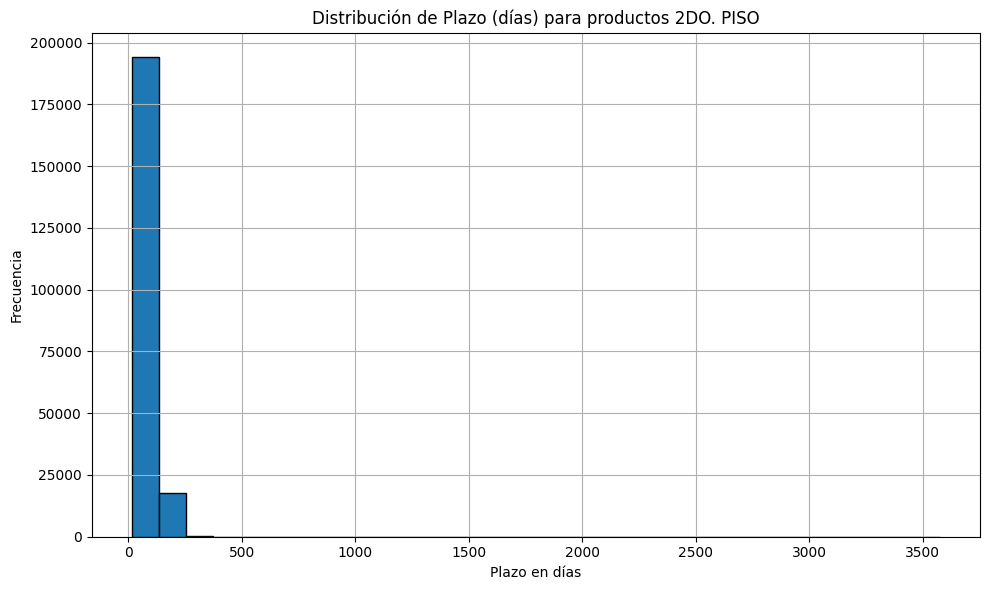

In [60]:
import matplotlib.pyplot as plt
productos_deseados = [
    "2DO. PISO, M.N. HABILITACION O AVIO",
    "2DO. PISO, DLLS. HABILITACION O AVIO"
]

df_filtrado = df[df["PRODUCTO"].isin(productos_deseados)]

df_filtrado["PLAZO"] = pd.to_numeric(df_filtrado["PLAZO"], errors="coerce")


plt.figure(figsize=(10, 6))
plt.hist(df_filtrado["PLAZO"].dropna(), bins=30, edgecolor='black')
plt.title("Distribución de Plazo (días) para productos 2DO. PISO")
plt.xlabel("Plazo en días")
plt.ylabel("Frecuencia")
plt.grid(True)
plt.tight_layout()
plt.show()

In [22]:
df_filtrado = df_clientes[df_clientes['SISTEMA_ORIGEN'].str.contains(',')]

In [22]:
df_filtrado

,ID_DL,NEGOCIO,NOMBRE_O_RAZON_SOCIAL,NUMERO_CLIENTE,ESTATUS,NUMERO_CONTRATO,GENERO,FECHA_NAC_O_CONST,ENTIDAD_FEDERATIVA_NACIMIENTO,PAIS_DE_NACIMIENTO,...,TELEFONO,CORREO_ELECTRONICO,RFC,CURP,FIEL,REPRESENTANTE_LEGAL,TIPO_PERSONA,PRODUCTO_CONTRATADO,SISTEMA_ORIGEN,FECHA_DE_ACTUALIZACION
241,12716,Sin información,"AFIX SERVICIOS FINANCIEROS, S.A.P.I. DE C.V. S...","28563824, 1065491",VIGENTE,Sin información,NO APLICA,Sin información,Sin información,Sin información,...,", 36301888",,"ASF0901169V3, ASF-090116-9V3",Sin información,Sin información,"Datos de la Escritura , HEREDIA HORNER HUGO","PM, Moral Nacional no Gravable",Sin información,"SIRAC, TAS",16/05/25
521,12717,Sin información,"ALSOL CONTIGO, S.A. DE C.V., SOFOM, E.N.R.","28627541, 1065418, 1065564",VIGENTE,Sin información,NO APLICA,Sin información,Sin información,Sin información,...,", 9676781434",,"ACO090216551, ACO-090216-551",Sin información,Sin información,"Datos de la Escritura , GONZALEZ GARCIA DARIO ...","PM, Moral Nacional Gravable",Sin información,"SIRAC, TAS",16/05/25
789,12718,Sin información,APOYO ECONOMICO FAMILIAR SA DE CV SOFOM ENR,"22336018, 1064485",VIGENTE,Sin información,NO APLICA,Sin información,Sin información,Sin información,...,", 55 5229 0200",,"AEF-050221-TY2, AEF050221TY2",Sin información,Sin información,"Datos de la Escritura , MESSMACHER HENRIQUEZ E...","PM, Moral Nacional no Gravable",Sin información,"SIRAC, TAS",16/05/25
1130,12766,Sin información,"BANCA AFIRME, S.A.","306, 1041222",VIGENTE,Sin información,NO APLICA,Sin información,Sin información,Sin información,...,,,BAF950102JP5,Sin información,Sin información,"ARZATE ORTIZ RAUL ROSENDO , ASMITIA ANCONA JOA...","PM, Moral Nacional no Gravable",Sin información,"SIPE, TAS",16/05/25
1134,1028,Sin información,"BANCA CREMI,S.A.","BCDI, 77",VIGENTE,Sin información,NO APLICA,Sin información,Sin información,Sin información,...,Sin información,Sin información,XXXXXXXXXXXXX,Sin información,Sin información,Sin información,PM,Sin información,"SIPE, MECA",16/05/25
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11716,12763,Sin información,"SOFIPA CORPORATION, S.A.P.I. DE C.V., SOFOM E....","28917282, 1065803",VIGENTE,Sin información,NO APLICA,Sin información,Sin información,Sin información,...,", 95 1501 7100",,"FIN080623RZ8, FIN-080623-RZ8",Sin información,Sin información,"Datos de la Escritura , GARCIA VERA GABRIEL , ...","PM, Moral Nacional no Gravable",Sin información,"SIRAC, TAS",16/05/25
12257,10329,Sin información,TRATON FINANCIAL SERVICES MEXICO S.A. DE C.V. ...,"4581019, 90066",VIGENTE,Sin información,NO APLICA,Sin información,Sin información,MEXICO,...,52626674 -- 52626690 -- 5552628690 -- 55555555,Sin información,"NFI-980108-PX5, NFI980108PX5",Sin información,Sin información,Sin información,"UNIONES DE CREDITO, PM",Sin información,"SIRAC, SIAG",16/05/25
12337,10402,Sin información,UNION BANK OF SWITZERLAND,"10459, UBS, 5",VIGENTE,Sin información,NO APLICA,Sin información,Sin información,Sin información,...,800 813 9224,Sin información,XXXXXXXXXXXXX,Sin información,Sin información,Sin información,PM,Sin información,"SIPE, SOI, MECA",16/05/25
12393,12764,UNIDAD DE MERCADO DE CAPITALES,"VALORES MEXICANOS CASA DE BOLSA, S.A. DE C.V.","VALMEX, 1057519, 315",VIGENTE,Sin información,NO APLICA,Sin información,Sin información,Sin información,...,", 566 6211, 5279 1200",,"XXXXXXXXXXXXX, CBC79081421A, VMC930101JS6",Sin información,Sin información,"ALVAREZ TOLEDO CLAUDIA CECILIA , Datos de la E...","PM, Moral Nacional no Gravable",Sin información,"TAS, MECA",16/05/25


In [23]:
df_filtrado

,ID_DL,NEGOCIO,NOMBRE_O_RAZON_SOCIAL,NUMERO_CLIENTE,ESTATUS,NUMERO_CONTRATO,GENERO,FECHA_NAC_O_CONST,ENTIDAD_FEDERATIVA_NACIMIENTO,PAIS_DE_NACIMIENTO,...,CORREO_ELECTRONICO,RFC,CURP,FIEL,REPRESENTANTE_LEGAL,TIPO_PERSONA,PRODUCTO_CONTRATADO,SISTEMA_ORIGEN,FECHA_DE_ACTUALIZACION,map_ids
234,12518,Sin información,"AFIX SERVICIOS FINANCIEROS, S.A.P.I. DE C.V. S...","28563824, 1065491",VIGENTE,Sin información,NO APLICA,Sin información,Sin información,Sin información,...,,"ASF0901169V3, ASF-090116-9V3",Sin información,Sin información,"Datos de la Escritura , HEREDIA HORNER HUGO","PM, Moral Nacional no Gravable",Sin información,"TAS, SIRAC",21/05/25,"[TAS, 1065491], [SIRAC, 28563824]"
507,12519,Sin información,"ALSOL CONTIGO, S.A. DE C.V., SOFOM, E.N.R.","28627541, 1065418, 1065564",VIGENTE,Sin información,NO APLICA,Sin información,Sin información,Sin información,...,,"ACO-090216-551, ACO090216551",Sin información,Sin información,"Datos de la Escritura , GONZALEZ GARCIA DARIO ...","PM, Moral Nacional Gravable",Sin información,"TAS, SIRAC",21/05/25,"[SIRAC, 28627541], [TAS, 1065564], [TAS, 1065418]"
774,12520,Sin información,APOYO ECONOMICO FAMILIAR SA DE CV SOFOM ENR,"22336018, 1064485",VIGENTE,Sin información,NO APLICA,Sin información,Sin información,Sin información,...,,"AEF050221TY2, AEF-050221-TY2",Sin información,Sin información,"Datos de la Escritura , MESSMACHER HENRIQUEZ E...","PM, Moral Nacional no Gravable",Sin información,"TAS, SIRAC",21/05/25,"[SIRAC, 22336018], [TAS, 1064485]"
1108,12568,Sin información,"BANCA AFIRME, S.A.","306, 1041222",VIGENTE,Sin información,NO APLICA,Sin información,Sin información,Sin información,...,,BAF950102JP5,Sin información,Sin información,"ARZATE ORTIZ RAUL ROSENDO , ASMITIA ANCONA JOA...","PM, Moral Nacional no Gravable",Sin información,"TAS, SIPE",21/05/25,"[SIPE, 306], [TAS, 1041222]"
1112,1006,Sin información,"BANCA CREMI,S.A.","BCDI, 77",VIGENTE,Sin información,NO APLICA,Sin información,Sin información,Sin información,...,Sin información,XXXXXXXXXXXXX,Sin información,Sin información,Sin información,PM,Sin información,"SIPE, MECA",21/05/25,"[MECA, BCDI], [SIPE, 77]"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11548,12565,Sin información,"SOFIPA CORPORATION, S.A.P.I. DE C.V., SOFOM E....","28917282, 1065803",VIGENTE,Sin información,NO APLICA,Sin información,Sin información,Sin información,...,,"FIN-080623-RZ8, FIN080623RZ8",Sin información,Sin información,"Datos de la Escritura , GARCIA VERA GABRIEL , ...","PM, Moral Nacional no Gravable",Sin información,"TAS, SIRAC",21/05/25,"[SIRAC, 28917282], [TAS, 1065803]"
12076,10148,Sin información,TRATON FINANCIAL SERVICES MEXICO S.A. DE C.V. ...,"4581019, 90066",VIGENTE,Sin información,NO APLICA,Sin información,Sin información,MEXICO,...,Sin información,"NFI-980108-PX5, NFI980108PX5",Sin información,Sin información,Sin información,"PM, UNIONES DE CREDITO",Sin información,"SIAG, SIRAC",21/05/25,"[SIRAC, 4581019], [SIAG, 90066]"
12153,10218,Sin información,UNION BANK OF SWITZERLAND,"10459, UBS, 5",VIGENTE,Sin información,NO APLICA,Sin información,Sin información,Sin información,...,Sin información,XXXXXXXXXXXXX,Sin información,Sin información,Sin información,PM,Sin información,"SIPE, MECA, SOI",21/05/25,"[SIPE, 5], [MECA, UBS], [SOI, 10459]"
12209,12566,UNIDAD DE MERCADO DE CAPITALES,"VALORES MEXICANOS CASA DE BOLSA, S.A. DE C.V.","VALMEX, 1057519, 315",VIGENTE,Sin información,NO APLICA,Sin información,Sin información,Sin información,...,,"VMC930101JS6, CBC79081421A, XXXXXXXXXXXXX",Sin información,Sin información,"ALVAREZ TOLEDO CLAUDIA CECILIA , Datos de la E...","PM, Moral Nacional no Gravable",Sin información,"TAS, MECA",21/05/25,"[TAS, 315], [TAS, 1057519], [MECA, VALMEX]"


In [14]:
df_filtrado["SOXID"] = df_filtrado.apply(
    lambda row: {f"{so}:{id}" for so, id in zip(row["SISTEMA_ORIGEN"].split(","), row["NUMERO_CLIENTE"].split(","))},
    axis=1
)


/tmp/ipykernel_24838/3449657443.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtrado["SOXID"] = df_filtrado.apply(
